## Set up all the needed packages

### Abstract

This project is trying to predict the presidential election and base on the races variable, three different machine learning model has been trained to find the best one for prediction. After that, from the best I will apply 2019's population data to predict the outcome of the votes. 

### Setup  all needed pakages

I will use some helper packages like pandas, plotly statistics and math. Moreover, I will focus on sklearn packages for doing machine learning models like Linear Regression, KNN Regression, GradientBoosting Regression, to predict the outcome

### Set up all data needed

Since the data is so big, I recommend that download the data into the current directory that hold this project in order to make this project work:

a.) https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/42MVDX/MFU99O&version=5.0

b.) https://www.kaggle.com/joelwilson/2012-2016-presidential-elections?select=county_facts.csv

c.) https://www.kaggle.com/joelwilson/2012-2016-presidential-elections?select=votes.csv

d.) https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/asrh/cc-est2019-alldata.csv

In [87]:
import pandas as pd
import plotly.graph_objects as go # need to install plotly
import statistics as st
import math as ma
from operator import itemgetter

# I'm using Anaconda so run admin command prompt -> conda install -c https://conda.anaconda.org/plotly plotly
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, GridSearchCV #knn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

### Background

We will have an overview about how voting data looks like over the past 10 voting elections - or nearly 40 years. This background analysis can answer what political party each states vote for in last 10 times. Is the state recently a one-sided political party state or can still flip the count to another political party.

In [88]:
# data reference # https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/42MVDX/MFU99O&version=5.0
data = pd.read_csv('1976-2016-president.csv') 

In [89]:
def init_state():
    all_state = {}
    state_abr = {}
    for idx in range (len(data)):
        state_name = data['state'][idx]
        if state_name not in all_state:
            all_state[state_name] = ""
            state_abr[state_name] = data['state_po'][idx]
    return all_state, state_abr
all_state, state_abr = init_state()

In [90]:
def analyze_year(temp_df):
    try: 
        party1 = round(temp_df['candidatevotes'][0]/ temp_df['totalvotes'][0]*100, 2)
        party2 = round(temp_df['candidatevotes'][1]/ temp_df['totalvotes'][0]*100, 2)
        party3 = round(temp_df['candidatevotes'][2]/ temp_df['totalvotes'][0]*100, 2)
    except:
        party3 = 0
    finally:
        retdf = {"state": [temp_df['state'][0]],  
                 "state_abbreviation": [temp_df['state_po'][0]],
                 "year": [temp_df['year'][0]],
                 "party1": [temp_df['party'][0]],
                 "per_votes1 (%)": party1,
                 "party2": temp_df['party'][1],
                 "per_votes2 (%)": party2,
                 "party3": "Others",
                 "per_votes3 (%)": party3,
                 "perdiff": party1 - party2 } # only the diff 
    df = pd.DataFrame(data=retdf)
    return df

In [91]:
tempdf = {"state": ["0"],  
          "state_abbreviation": ["0"],
          "year": [0],
          "party1": ["0"],
          "per_votes1 (%)": [0],
          "party2": ["0"],
          "per_votes2 (%)": [0],
          "party3": ["Others"],
          "per_votes3 (%)": [0],
          "perdiff": [0]
         }

resultdf = pd.DataFrame(data=tempdf)
for state_name in all_state.keys():
    for yr in range(1976, 2020, 4):
        #print(yr)
        sub_df = data[(data.state == state_name) & (data.year == yr)]
        sub_df.reset_index(drop=True, inplace=True)
        analyzed_df = analyze_year(sub_df)
        #print(analyzed_df)
        resultdf = pd.concat([resultdf, analyzed_df], join="inner")
        all_state[state_name]

resultdf = resultdf.iloc[1:]
resultdf.reset_index(drop=True, inplace=True)

In [92]:
def party_initialize(all_state, diff):
    # the dictionary from the beginning
    # difference between top 2 party
    copy_state = all_state.copy() # make copy and return the copy only
    for state_name in all_state.keys():
        demo = 0
        rep = 0
        temp = resultdf[(resultdf.state == state_name)]
        temp.reset_index(drop=True, inplace=True)
        for i in range(5, 10): # 5 most recent votes
            if temp['perdiff'][i] >= diff:
                if temp['party1'][i] == "democrat":
                    demo += 1
                else:
                    rep += 1
        if demo >= 4: # 4 or 5 recents vote are resulted in the same party
            copy_state[state_name] = 1 # 1 = democratic
        elif rep >=4:
            copy_state[state_name] = -1 # -1 = republican
        else:
            copy_state[state_name] = 0 # undecided
    return copy_state

all_state1 = party_initialize(all_state, 1)
all_state2 = party_initialize(all_state, 10)
all_state3 = party_initialize(all_state, 20)

In [93]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
    x= [k for k in all_state1.keys()],
    y= [v+1 for v in all_state1.values()],
    marker=dict(color="red", size=12),
    mode="markers",
    name="1% different between 2 highest party"
))
fig.add_trace(
    go.Scatter(
    x= [k for k in all_state2.keys()],
    y= [v+10 for v in all_state2.values()],
    marker=dict(color="green", size=12),
    mode="markers",
    name="10% different between 2 highest party"    
))
fig.add_trace(
    go.Scatter(
    x= [k for k in all_state3.keys()],
    y= [v+20 for v in all_state3.values()],
    marker=dict(color="blue", size=12),
    mode="markers",
    name="20% different between 2 highest party"
))
fig.write_image("fig1.png") # check your fig1.png if this doesn't show up, 
#The plot is interactive, you can click on it to see the name of the state.
fig.show()

In [94]:
# get the state that is one-sided (at 20% diff every year)
democratic_state = []
republican_state = []
for k in all_state3.keys():
    if all_state3[k] == 1:
        democratic_state.append(k)
    elif all_state3[k] == -1:
        republican_state.append(k)

In [95]:
print(democratic_state)

['District of Columbia', 'Massachusetts', 'New York', 'Rhode Island', 'Vermont']


In [96]:
print(republican_state)

['Idaho', 'Oklahoma', 'Utah', 'Wyoming']


As we can see, with 20% difference, there are still states that support a specific party:

Democratic: District of Columbia, Massachusetts, New York, Rhode Islands, Vermont

Republican: Idaho, Oklahoma, Utah, Wyoming.

### Building up machine learning models

As I mentioned, I will apply Linear Regression Model, KNN Regression Model, Gradient Boosting Regression Model for the analysis. The variables that I will focus on this project is races, more specificially 'White', 'Black', 'Native', 'Asian', 'Hawaiian' in each of the county in the United States.

In [97]:
# https://www.kaggle.com/joelwilson/2012-2016-presidential-elections?select=county_facts.csv
# https://www.kaggle.com/joelwilson/2012-2016-presidential-elections?select=votes.csv
countydata = pd.read_csv('county_facts.csv')
votedata = pd.read_csv('votes.csv')
countydata.head(5)
countydata = countydata[countydata.state_abbreviation.notnull()]

countydata.reset_index(drop=True, inplace=True)
votedata.reset_index(drop=True, inplace=True)

countydata.rename(columns = {'RHI125214': 'White', 
                             'RHI225214': 'Black', 
                             'RHI325214': 'Native', 
                             'RHI425214': 'Asian', 
                             'RHI525214': 'Hawaiian',
                             'RHI725214': 'Hispanic'}, inplace = True) 
votedata.rename(columns = {'RHI325214': 'Native', 
                           'RHI425214': 'Asian', 
                           'RHI525214': 'Hawaiian',
                           'RHI725214': 'Hispanic',
                           'POP010210': 'population_2010'}, inplace = True) 
votedata.reset_index(drop=True, inplace=True)
votedata.insert(2, "population_2014", countydata['PST045214'], True) 
race = ['White', 'Black', 'Native', 'Asian', 'Hawaiian']

In [98]:
#list(votedata.columns) 
#per_point_diff_2016
#per_point_diff_2012

In [99]:
# Asian
# RHI125214: White alone, percent, 2014
# RHI225214: Black or African American alone, percent, 2014
# RHI325214: American Indian and Alaska Native alone, percent, 2014
# RHI425214: Asian alone, percent, 2014
# RHI525214: Native Hawaiian and Other Pacific Islander alone, percent, 2014
# RHI625214: Two or More Races, percent, 2014
# RHI725214: Hispanic or Latino, percent, 2014

countydata = countydata[['area_name','state_abbreviation','White', 'Black', 'Native', 'Asian', 'Hawaiian']]
counties = countydata['area_name'].tolist()
countydata.head(5)

,area_name,state_abbreviation,White,Black,Native,Asian,Hawaiian
0,Autauga County,AL,77.9,18.7,0.5,1.1,0.1
1,Baldwin County,AL,87.1,9.6,0.7,0.9,0.1
2,Barbour County,AL,50.2,47.6,0.6,0.5,0.2
3,Bibb County,AL,76.3,22.1,0.4,0.2,0.1
4,Blount County,AL,96.0,1.8,0.6,0.3,0.1


In [100]:
votedata

,Unnamed: 0,X,population_2014,combined_fips,votes_dem_2016,votes_gop_2016,total_votes_2016,Clinton,Trump,diff_2016,...,AFN120207,BPS030214,LND110210,Density,Clinton_Obama,Trump_Romney,Trump_Prediction,Clinton_Prediction,Trump_Deviation,Clinton_Deviation
0,30,29,55395,1001,5908,18110,24661,0.239569,0.734358,12202,...,88157,131,594.44,91.8,-0.026189,0.008021,0.620859,0.340493,-0.113499,0.100924
1,31,30,200111,1003,18409,72780,94090,0.195653,0.773515,54371,...,436955,1384,1589.78,114.6,-0.020013,-0.000383,0.586749,0.359502,-0.186766,0.163849
2,32,31,26887,1005,4848,5431,10390,0.466603,0.522714,583,...,0,8,884.88,31.0,-0.045920,0.039339,0.517832,0.474693,-0.004882,0.008090
3,33,32,22506,1007,1874,6733,8748,0.214220,0.769662,4859,...,10757,19,622.58,36.8,-0.047965,0.038998,0.692227,0.286031,-0.077434,0.071811
4,34,33,57719,1009,2150,22808,25384,0.084699,0.898519,20658,...,20941,3,644.78,88.9,-0.038779,0.033590,0.789649,0.177490,-0.108870,0.092791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107,3137,3136,115290,56037,3233,12153,16661,0.194046,0.729428,8920,...,150439,227,10426.65,4.2,-0.090909,0.047219,0.665093,0.272789,-0.064335,0.078743
3108,3138,3137,20540,56039,7313,3920,12176,0.600608,0.321945,3393,...,327363,145,3995.38,5.3,0.053672,-0.105847,0.425316,0.494972,0.103372,-0.105635
3109,3139,3138,29509,56041,1202,6154,8053,0.149261,0.764187,4952,...,35497,40,2081.26,10.1,-0.043333,-0.018139,0.685461,0.256831,-0.078726,0.107570
3110,3140,3139,30362,56043,532,2911,3715,0.143203,0.783580,2379,...,10175,4,2238.55,3.8,-0.059814,0.013189,0.632028,0.305111,-0.151552,0.161908


In [101]:
#list(votedata.columns) 

In [102]:
votedata = votedata[['area_name','state_abbreviation','population_2010', 'population_2014',
                     'total_votes_2012', 'votes_dem_2012', 'votes_gop_2012', 'diff_2012', 
                     'total_votes_2016', 'votes_dem_2016', 'votes_gop_2016', 'diff_2016'] + race]
votedata['Asian'] = votedata['Asian'] / 100
votedata.head(10)

<ipython-input-102-fe7fbf58981e>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,area_name,state_abbreviation,population_2010,population_2014,total_votes_2012,votes_dem_2012,votes_gop_2012,diff_2012,total_votes_2016,votes_dem_2016,votes_gop_2016,diff_2016,White,Black,Native,Asian,Hawaiian
0,Autauga County,AL,54571,55395,23909,6354,17366,11012,24661,5908,18110,12202,0.779,0.187,0.5,0.011,0.1
1,Baldwin County,AL,182265,200111,84988,18329,65772,47443,94090,18409,72780,54371,0.871,0.096,0.7,0.009,0.1
2,Barbour County,AL,27457,26887,11459,5873,5539,334,10390,4848,5431,583,0.502,0.476,0.6,0.005,0.2
3,Bibb County,AL,22915,22506,8391,2200,6131,3931,8748,1874,6733,4859,0.763,0.221,0.4,0.002,0.1
4,Blount County,AL,57322,57719,23980,2961,20741,17780,25384,2150,22808,20658,0.960,0.018,0.6,0.003,0.1
5,Bullock County,AL,10914,10764,5318,4058,1250,2808,4701,3530,1139,2391,0.269,0.701,0.8,0.003,0.7
6,Butler County,AL,20947,20296,9483,4367,5081,714,8685,3716,4891,1175,0.539,0.440,0.4,0.009,0.0
7,Calhoun County,AL,118572,115916,46240,15500,30272,14772,47376,13197,32803,19606,0.758,0.211,0.5,0.009,0.1
8,Chambers County,AL,34215,34076,14562,6853,7596,743,13778,5763,7803,2040,0.583,0.395,0.3,0.008,0.1
9,Cherokee County,AL,25989,26037,9761,2126,7494,5368,10503,1524,8809,7285,0.930,0.046,0.5,0.003,0.0


In [103]:
for r in race:
    votedata[r] = round(votedata[r]* (votedata['population_2010'] * 1.07**2))
    
votedata["population_2012"] = round(votedata["population_2010"] * (1.07)**4)
votedata["population_2016"] = round(votedata["population_2014"] * (1.07)**4)

<ipython-input-103-38714de2e884>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-103-38714de2e884>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-103-38714de2e884>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [104]:
votes_2012 = votedata[['area_name', 'state_abbreviation', 'population_2012', 
                       'diff_2012', 'votes_gop_2012', 'votes_dem_2012'] + race ]
votes_2016 = votedata[['area_name', 'state_abbreviation', 'population_2016', 
                       'diff_2016', 'votes_gop_2016', 'votes_dem_2016'] + race ]


In [105]:
#set up data for pre model
def setup_data2012(inputdf, partyvar, partypred):
    np.random.seed(4650)
    variable = race + ['diff_2012', partyvar]
    x = inputdf[variable].values
    y = inputdf[partypred].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)
    return x_train, y_train, x_test, y_test


# Linear regression
def fit_lr_model(x_train, y_train):
    np.random.seed(4650)
    model = linear_model.LinearRegression()
    model.fit(x_train, y_train)
    return model 

#graph out linear regression for the data
def graph_linear_regression(y_pred, y_test):
    np.random.seed(4650)
    plt.scatter(y_pred, y_test,  color='gray')
    m, b = np.polyfit(y_test, y_pred, 1)
    plt.plot(y_test, m*y_test + b)
    plt.show()

    
# knn neighbors -> return the k that has the highest test score
def get_best_knn_model(x_train, y_train, x_test, y_test):
    np.random.seed(4650)
    maxTuple = 0
    maxId = 0
    for k in range(1, 101):
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(x_train, y_train)
        scores = model.score(x_test, y_test)
        if maxTuple < scores: 
            maxTuple = scores
            maxId = k
    return (maxId, maxTuple) 

    
# get all the knn values
def graph_knn_model(x_train, y_train, x_test, y_test):
    np.random.seed(4650)
    rmse = []
    errorId = 0
    minimum = 100000000
    for k in range(1, 101):
        model = KNeighborsRegressor(n_neighbors= k)
        model.fit(x_train, y_train)
        pred = model.predict(x_test)  
        error = ma.sqrt(mean_squared_error(y_test, pred))
        if error < minimum:
            errorId = k
            minimum = error
        rmse.append(error)
    
    curve = pd.DataFrame(rmse) #elbow curve 
    print("ErrorID ", errorId, "Minimum ", minimum)
    curve.plot()
    
    
# Gradient Boosting Model
def fit_gbm_model(x_train, y_train):
    np.random.seed(4650)
    model = GradientBoostingRegressor(random_state=0)
    model.fit(x_train, y_train)
    return model

### Approaches

First of all, I'm going to check on how good those models are, recorded the value and then apply the best model to predict for gop and for dem to the year of 2016. Next, I'm going to compare the actual vote value of 2016 to the predicted one to see how good my model is. Then I will apply the best from those to 2019 data to predict that will the result be like.

On how well the model is, we mostly focus on the score given by the model, it will range from 0 - 1.0 in the percentage scaling, so the higher the score, the better the model

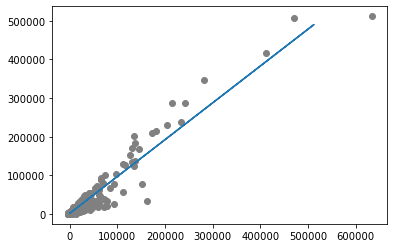

176450762.89956635
0.9231709895220358


In [106]:
np.random.seed(4650)
x_train, y_train, x_test, y_test = setup_data2012(votes_2012, 'votes_gop_2012', 'votes_dem_2012')
lrmodel_dem = fit_lr_model(x_train, y_train)
y_pred_dem = lrmodel_dem.predict(x_test)
graph_linear_regression(y_pred_dem, y_test)
lr_dem2012_score = r2_score(y_test, y_pred_dem)
print(mean_squared_error(y_test, y_pred_dem)) # the average squared difference between the estimated values and the actual value.
print(lr_dem2012_score)  # evaluate the performance of a linear regression model. 

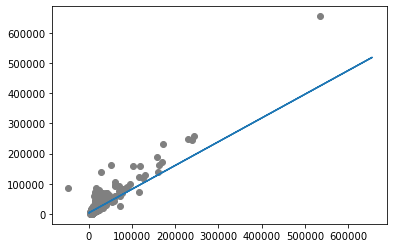

187495515.5182851
0.7660456158626969


In [107]:
np.random.seed(4650)
x_train, y_train, x_test, y_test = setup_data2012(votes_2012, 'votes_dem_2012', 'votes_gop_2012')
lrmodel_gop = fit_lr_model(x_train, y_train)
y_pred_gop = lrmodel_gop.predict(x_test)
graph_linear_regression(y_pred_gop, y_test)
lr_gop2012_score = r2_score(y_test, y_pred_dem)

print(mean_squared_error(y_test, y_pred_gop)) # the average squared difference between the estimated values and the actual value.
print(lr_gop2012_score)  # evaluate the performance of a linear regression model. 

9 0.9341534201302327
ErrorID  9 Minimum  12297.469708571765


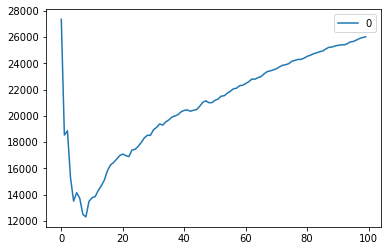

In [108]:
np.random.seed(4650)
x_train, y_train, x_test, y_test = setup_data2012(votes_2012, 'votes_gop_2012', 'votes_dem_2012')
maxId, knn_dem2012_score = get_best_knn_model(x_train, y_train, x_test, y_test)
print (maxId, knn_dem2012_score) 
graph_knn_model(x_train, y_train, x_test, y_test)

9 0.7880467848734731
ErrorID  9 Minimum  18529.222061920547


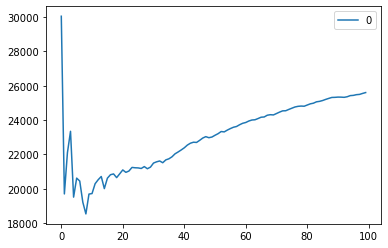

In [109]:
np.random.seed(4650)
x_train, y_train, x_test, y_test = setup_data2012(votes_2012, 'votes_dem_2012', 'votes_gop_2012')
maxId, knn_pop2012_score = get_best_knn_model(x_train, y_train, x_test, y_test)
print (maxId, knn_pop2012_score) 
graph_knn_model(x_train, y_train, x_test, y_test)

In [110]:
# evaluate the gbm model
np.random.seed(4650)
x_train, y_train, x_test, y_test = setup_data2012(votes_2012, 'votes_gop_2012', 'votes_dem_2012')
model = fit_gbm_model(x_train, y_train)
gbm_dem2012_score = model.score(x_test, y_test)
print(gbm_dem2012_score)

0.8123596417049499


In [111]:
# evaluate the gbm model
np.random.seed(4650)
x_train, y_train, x_test, y_test = setup_data2012(votes_2012, 'votes_dem_2012', 'votes_gop_2012')
model = fit_gbm_model(x_train, y_train)
gbm_pop2012_score = model.score(x_test, y_test)
print(gbm_pop2012_score)

0.9386144021197498


As we can see that for Democratic, the Linear Regression has the highest score and for Republican, the Gradient Boosting Method has the the highest score

In [112]:
presidential = {
        'Model': ["Linear Reg2012", "KNN2012", "GBM2012"],
        'R2_score Democratic': [lr_dem2012_score*100, knn_dem2012_score*100, gbm_dem2012_score*100],
        'R2_score Republican': [lr_gop2012_score*100, knn_pop2012_score*100, gbm_pop2012_score*100, ]
       }

df = pd.DataFrame(presidential, columns = ['Model', 'R2_score Democratic', 'R2_score Republican'])
df

,Model,R2_score Democratic,R2_score Republican
0,Linear Reg2012,92.317099,76.604562
1,KNN2012,93.415342,78.804678
2,GBM2012,81.235964,93.861440


For Democratic: Apply KNN model from 2012 to the data of 2016 to see how well the data works, then compare it with the model that trains with the actual 2016 data

For Republican: Apply GBM model from 2012 to the data of 2016 to see how well the data works, then compare it with the model that trains with the actual 2016 data

In [113]:
np.random.seed(4650)
variable2012 = race + ['diff_2012', 'votes_gop_2012']
x_train = votes_2012[variable2012].values
y_train = votes_2012['votes_dem_2012'].values

variable2016 = race + ['diff_2016', 'votes_gop_2016']
x_expect = votes_2016[variable2016].values
y_expect = votes_2016['votes_dem_2016'].values

knnmodel = KNeighborsRegressor(n_neighbors= 9) # here k is 9 get from above
knnmodel.fit(x_train, y_train)
ypred = knnmodel.predict(x_expect)

apply_dem2016_score = knnmodel.score(x_expect, y_expect)
apply_dem2016_mse = ma.sqrt(mean_squared_error(y_expect, ypred))
print(apply_dem2016_score, apply_dem2016_mse) # the average squared difference between the estimated values and the actual value, 
# evaluate the performance of a linear regression model.

0.7640053902567893 34923.78423991075


In [114]:
# evaluate the gbm model
np.random.seed(4650)
variable2012 = race + ['diff_2012', 'votes_dem_2012']
x_train = votes_2012[variable2012].values
y_train = votes_2012['votes_gop_2012'].values

variable2016 = race + ['diff_2016', 'votes_dem_2016']
x_expect = votes_2016[variable2016].values
y_expect = votes_2016['votes_gop_2016'].values

gbmmodel = fit_gbm_model(x_train, y_train)
gbm_applied_score = gbmmodel.score(x_expect, y_expect)
print(gbm_applied_score)

0.969348010033226


In [115]:
applied = {
        'Model': ["Applied KNN 2012", "Applied GBM 2012"],
        'R2_score Democratic': [apply_dem2016_score, 0],
        'R2_score Republican': [0, gbm_applied_score]
       }

dfnew = pd.DataFrame(applied, columns = ['Model', 'R2_score Democratic', 'R2_score Republican'])
dfnew

,Model,R2_score Democratic,R2_score Republican
0,Applied KNN 2012,0.764005,0.000000
1,Applied GBM 2012,0.000000,0.969348


Since the score for democratic model is pretty low, I decide to pick linear regression model to test with 2016 data .

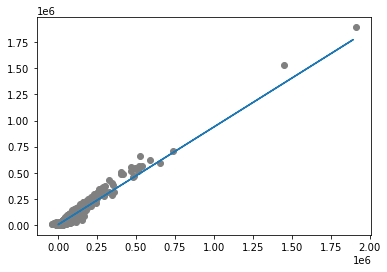

161511786.01956624
0.9687490150132401


In [116]:
np.random.seed(4650)
variable2012 = race + ['diff_2012', 'votes_gop_2012']
x_train = votes_2012[variable2012].values
y_train = votes_2012['votes_dem_2012'].values

variable2016 = race + ['diff_2016', 'votes_gop_2016']
x_expect = votes_2016[variable2016].values
y_expect = votes_2016['votes_dem_2016'].values

lrmodel_dem = fit_lr_model(x_train, y_train)
y_pred_dem = lrmodel_dem.predict(x_expect)

graph_linear_regression(y_pred_dem, y_expect)
lr_dem2012_score = r2_score(y_expect, y_pred_dem)
print(mean_squared_error(y_expect, y_pred_dem)) # the average squared difference between the estimated values and the actual value.
print(lr_dem2012_score)  # evaluate the performance of a linear regression model. 

It looks better with 0.9687490150132401 comparing to 0.764005

In [117]:
#2019 population
# https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/asrh/cc-est2019-alldata.csv
# data layout to keep track
# https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2019/cc-est2019-alldata.pdf 
data2019 = pd.read_csv('est2019-alldata.csv', encoding = "ISO-8859-1") 
# We only want the last year in the dataset which is YEAR 10 or 2019 and age group that is old enough to vote which is 5 or more
data2019 = data2019[(data2019['YEAR'] == 10) & (data2019['AGEGRP'] >= 5)]
data2019.reset_index(drop=True, inplace=True)

In [118]:
data2019['area_name'] = data2019['CTYNAME']
data2019['White'] = data2019['WA_MALE'] + data2019['WA_FEMALE']
data2019['Black'] = data2019['BA_MALE'] + data2019['BA_FEMALE'] 
data2019['Native'] = data2019['IA_MALE'] + data2019['IA_FEMALE'] 
data2019['Asian'] = data2019['AA_MALE'] + data2019['AA_FEMALE'] 
data2019['Hawaiian'] = data2019['NA_MALE'] + data2019['NA_FEMALE'] 

In [119]:
countydata2019 = data2019[['STNAME', 'area_name', 'TOT_POP','White', 'Black', 'Native', 'Asian', 'Hawaiian']]
countydata2019.reset_index(drop=True, inplace=True)
countydata2019 = countydata2019.groupby(['STNAME', 'area_name'])['TOT_POP','White', 'Black', 'Native', 'Asian', 'Hawaiian'].sum().reset_index()
countydata2019['TotalVote'] = countydata2019['White'] + countydata2019['Black'] + countydata2019['Native'] + countydata2019['Asian'] + countydata2019['Hawaiian'] 
countydata2019.head(5)

<ipython-input-119-4e87b1589540>:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,STNAME,area_name,TOT_POP,White,Black,Native,Asian,Hawaiian,TotalVote
0,Alabama,Autauga County,40881,31922,7770,209,505,35,40441
1,Alabama,Baldwin County,161850,143530,13701,1250,1532,106,160119
2,Alabama,Barbour County,19406,9998,8992,123,92,36,19241
3,Alabama,Bibb County,17439,13336,3856,65,37,22,17316
4,Alabama,Blount County,43076,41584,650,274,116,46,42670


In [120]:
meandiff = st.mean(votes_2016['diff_2016'] - votes_2012['diff_2012'])
meangop = st.mean(votes_2016['votes_gop_2016'] - votes_2012['votes_gop_2012'])
for i in range(len(votes_2016), len(countydata2019)):
    votes_2016['diff_2016'][i] = meandiff
    votes_2016['votes_gop_2016'][i] = meangop

<ipython-input-120-f1f00950dfb9>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-120-f1f00950dfb9>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice 

In [121]:
#Use the model from Linear Regression 2016
np.random.seed(4650)
variable2012 = race + ['diff_2012', 'votes_gop_2012']
x_train = votes_2012[variable2012].values
y_train = votes_2012['votes_dem_2012'].values

countydata2019['diff_2016'] = votes_2016['diff_2016'] 
countydata2019['votes_gop_2016'] = votes_2016['votes_gop_2016'] 

variable2016 = race + ['diff_2016', 'votes_gop_2016']
x_predict2020 = countydata2019[variable2016].values 

lr_2020model = fit_lr_model(x_train, y_train)
y2020_pred_dem = lr_2020model.predict(x_predict2020)

In [122]:
np.random.seed(4650)
variable2012 = race + ['diff_2012', 'votes_dem_2012']
x_train = votes_2012[variable2012].values
y_train = votes_2012['votes_gop_2012'].values
gbm_2020model = fit_gbm_model(x_train, y_train)

variable2016 = race + ['diff_2016', 'votes_gop_2016']
x_predict2020 = countydata2019[variable2016].values 
y2020_pred_gop = gbm_2020model.predict(x_predict2020)

In [123]:
def analyze_state(state_df):
    rep = 0
    dem = 0
    na  = 0  # in case there is a county that is undecided.
    for i in range(len(state_df)):
        if state_df['Won'][i] == "Republican":
            rep += 1
        elif state_df['Won'][i] == 'Democratic':
            dem += 1
        else:
            na += 1
    if dem > rep:
        return 1
    else:
        return -1

Let's do some comparision on how the actual data from 2016 comparing to our prediting data from 2019 to see how well the models work and have some comments on the prediction

In [124]:
voteData = {
        'State': votedata['state_abbreviation'].values,
        'Democratic': ( votedata['votes_dem_2016'].values ),
        'Republican': ( votedata['votes_gop_2016'].values ),
       }

final2016_data = pd.DataFrame(voteData, columns = ['State','Democratic', 'Republican'])

temp = []
for r in range(len(final2016_data)):
    dem_val = final2016_data['Democratic'][r]
    rep_val = final2016_data['Republican'][r] 
    if dem_val > rep_val:
        temp.append('Democratic')
    elif dem_val < rep_val:
        temp.append('Republican')
    else:
        temp.append('Undecided')
        na += 1
        
final2016_data['Won'] = temp

In [125]:
dem2016 = 0
rep2016 = 0
for k in state_abr.keys():
    state_df = final2016_data[final2016_data['State'] == state_abr[k]]
    state_df.reset_index(drop=True, inplace=True)
    value = analyze_state(state_df)
    if value == 1:
        dem2016 += 1
    else:
        rep2016 += 1
  

In [126]:
voteData = {
        'State': countydata2019['STNAME'].values,
        'Democratic predicted': ( np.round(y2020_pred_dem) ),
        'Republican predicted': ( np.round(y2020_pred_gop) ),
       }

final_data = pd.DataFrame(voteData, columns = ['State','Democratic predicted', 'Republican predicted'])

temp = []
for r in range(len(final_data)):
    dem_val = final_data['Democratic predicted'][r]
    rep_val = final_data['Republican predicted'][r] 
    if dem_val > rep_val:
        temp.append('Democratic')
    elif dem_val < rep_val:
        temp.append('Republican')
    else:
        temp.append('Undecided')
        na += 1
final_data['Won'] = temp

In [127]:
#Look into 2019 data

In [128]:
dem2019 = 0
rep2019 = 0
for k in all_state.keys():
    state_df = final_data[final_data['State'] == k]
    state_df.reset_index(drop=True, inplace=True)
    value = analyze_state(state_df)
    if value == 1:
        dem2019 += 1
    else:
        rep2019 += 1

Text(0.5, 1.0, 'Party')

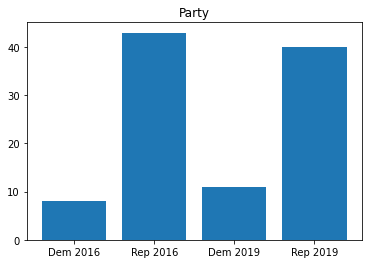

In [129]:
votes = [dem2016, rep2016, dem2019, rep2019]
names = ['Dem 2016', 'Rep 2016', 'Dem 2019', 'Rep 2019']

plt.bar(names, votes)
plt.title('Party')

Conclusion: It looks like there wil be a slightly move up on the number of Democratic party vote, however, the amount of Republican party vote is a lot so the predicted winner should be Republican side, which is Donald Trump.

### Take away from the project

Although we have really high points on the accuracy of the model, there are still many other variables that can affect to the results like poverty coverage, political movement, real - life debates. It will be more correct if I'm provided with those data.